Displaying SIFT Features...


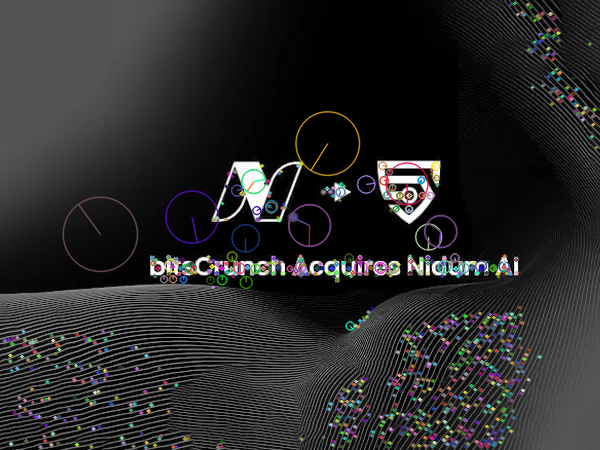

Displaying Feature Matching Results...


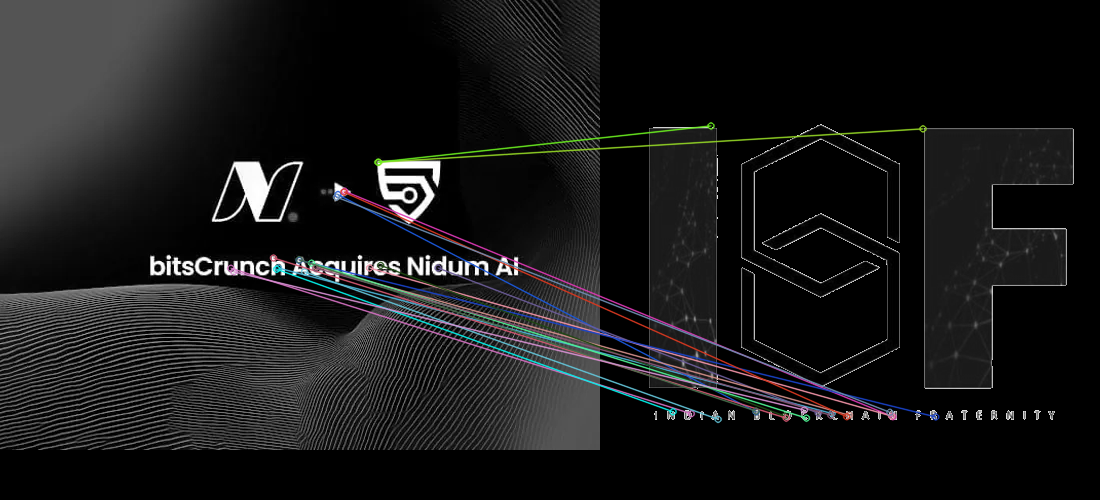

Displaying Watershed Contours...


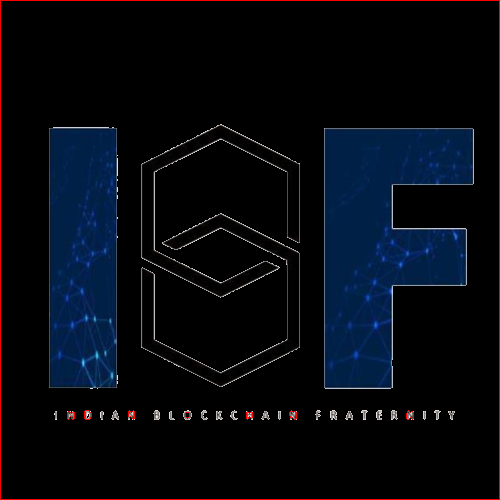

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

def sift_feature_detection(image_path):
    """Detects SIFT features and displays them."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error: Could not read image {image_path}")
        return

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    output = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    print("Displaying SIFT Features...")
    cv2_imshow(output)

def feature_matching(img1_path, img2_path):
    """Performs feature matching between two images using ORB and BFMatcher."""
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        print("Error: Could not read one or both images.")
        return

    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    if des1 is None or des2 is None:
        print("Error: No keypoints detected in one or both images.")
        return

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    result = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    print("Displaying Feature Matching Results...")
    cv2_imshow(result)

def contour_detection_watershed(image_path):
    """Performs contour detection using Watershed algorithm."""
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not read image {image_path}")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    markers = cv2.connectedComponents(sure_fg)[1]
    markers += 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(image, markers)
    image[markers == -1] = [0, 0, 255]


    print("Displaying Watershed Contours...")
    cv2_imshow(image)


sift_feature_detection("/content/20250306150939.webp")
feature_matching("/content/20250306150939.webp", "/content/thumbnail_Outlook-4dg4vads.png")
contour_detection_watershed("/content/thumbnail_Outlook-4dg4vads.png")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 182s 382ms/step - loss: 0.1161 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 352ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 352ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 196s 340ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 201s 338ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 345ms/step - loss: 0.1125 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 349ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 348ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 162s 346ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 338ms/step - loss: 0.1120 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
Averag

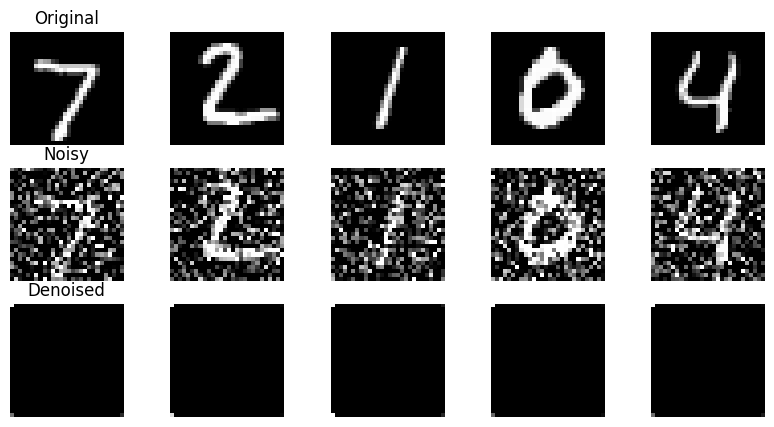

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from skimage.metrics import peak_signal_noise_ratio as psnr

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


def add_noise(imgs, noise_factor=0.5):
    noisy_imgs = imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgs.shape)
    return np.clip(noisy_imgs, 0.0, 1.0)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

input_layer = Input(shape=(28, 28, 1))

#Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)

#Decoder
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
output_layer = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                validation_data=(x_test_noisy, x_test))

x_test_denoised = autoencoder.predict(x_test_noisy)

psnr_value = np.mean([psnr(x_test[i], x_test_denoised[i]) for i in range(len(x_test))])
print(f"Average PSNR: {psnr_value:.2f} dB")

def plot_images(original, noisy, denoised, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(3, num_images, i+1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Original")

        plt.subplot(3, num_images, i+1+num_images)
        plt.imshow(noisy[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Noisy")

        plt.subplot(3, num_images, i+1+2*num_images)
        plt.imshow(denoised[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Denoised")

    plt.show()

plot_images(x_test, x_test_noisy, x_test_denoised)